In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import yfinance as yf
import datetime
import warnings
warnings.filterwarnings('ignore')


In [2]:
end = '2024-05-31'
start = '2019-1-1'

In [3]:
x = yf.download('HDFCBANK.NS',start,end)['Adj Close']
y = yf.download('KOTAKBANK.NS',start,end)['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [4]:
df = pd.concat([x,y],axis=1)
df.columns = ['HDFCBANK','KOTAKBANK']
df

,HDFCBANK,KOTAKBANK
Date,,
2019-01-01,1022.420837,1246.011597
2019-01-02,1013.091919,1236.196655
2019-01-03,1005.143127,1230.865601
2019-01-04,1007.832336,1243.520508
2019-01-07,1009.355347,1242.175293
...,...,...
2024-08-30,1636.900024,1780.800049
2024-09-02,1626.949951,1780.250000
2024-09-03,1637.349976,1783.800049


In [ ]:
print(df.isnull().sum())
print(np.isinf(df).sum())

In [5]:
df = df.replace([np.inf, -np.inf], np.nan).dropna()

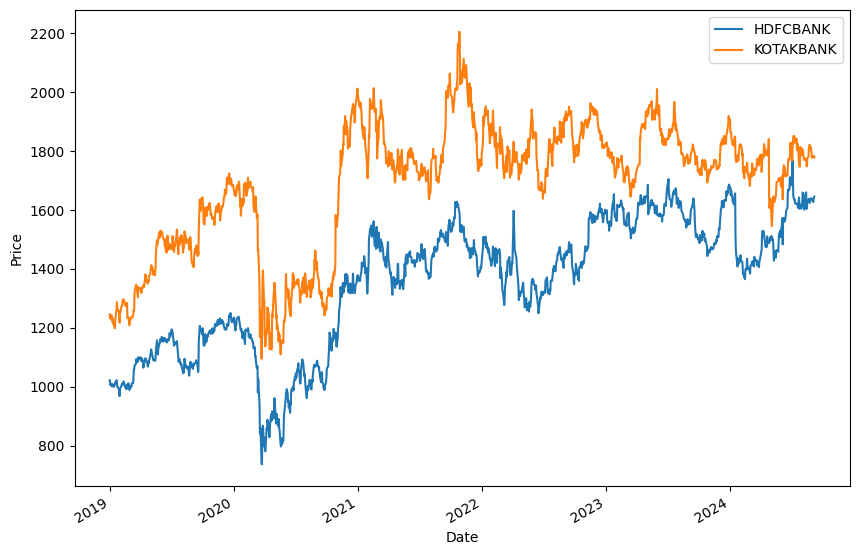

In [6]:
df.plot(figsize=(10,7))
plt.ylabel("Price")
plt.show()

In [7]:
X = df['HDFCBANK']
y = df['KOTAKBANK']

model = np.polyfit(X,y,deg=1)
hedge_ratio = model[0]
hr = round(hedge_ratio,3)
print(f'The hedge ratio is {hr}')

The hedge ratio is 0.863


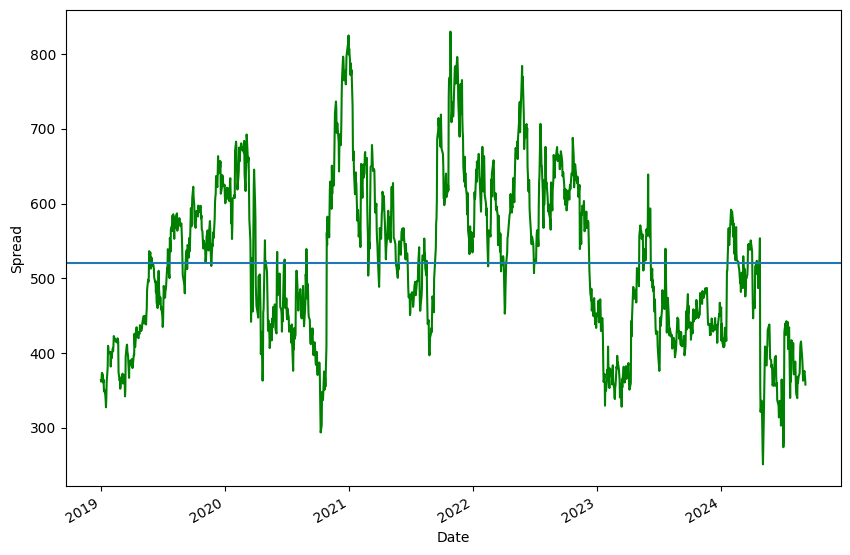

In [8]:
df['spread'] = df.KOTAKBANK - hr * df.HDFCBANK


df.spread.plot(figsize=(10,7), color='g')
plt.axhline(df.spread.mean())
plt.ylabel("Spread")

plt.show()

In [ ]:
!pip install statsmodels



In [9]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df.spread, maxlag=1)
print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
print("Critical Values:", adf_result[4])
if adf_result[1] < 0.05:
    print("The spread series is likely stationary.")
else:
    print("The spread series is likely not stationary.")

ADF Statistic: -4.083166906749702
p-value: 0.001032469938274249
Critical Values: {'1%': -3.4350261755253633, '5%': -2.8636051980916997, '10%': -2.56786950392322}
The spread series is likely stationary.


In [10]:
def mean_reversion_strategy(df, period, std_dev):
     # Moving Average
    df['moving_average'] = df.spread.rolling(period).mean()
    # Moving Standard Deviation
    df['moving_std_dev'] = df.spread.rolling(period).std()

    # Upper band and lower band
    df['upper_band'] = df.moving_average + std_dev * df.moving_std_dev
    df['lower_band'] = df.moving_average - std_dev * df.moving_std_dev

    # Long positions
    df['long_entry'] = df.spread < df.lower_band
    df['long_exit'] = df.spread >= df.moving_average
    df['positions_long'] = np.nan
    df.loc[df.long_entry, 'positions_long'] = 1
    df.loc[df.long_exit, 'positions_long'] = 0
    df.positions_long = df.positions_long.fillna(method='ffill')

    # Short positions
    df['short_entry'] = df.spread > df.upper_band
    df['short_exit'] = df.spread <= df.moving_average
    df['positions_short'] = np.nan
    df.loc[df.short_entry, 'positions_short'] = -1
    df.loc[df.short_exit, 'positions_short'] = 0
    df.positions_short = df.positions_short.fillna(method='ffill')

    # Combined positions
    df['positions'] = df.positions_long + df.positions_short

    return df


In [11]:
df = mean_reversion_strategy(df,30,1)
df.dropna(inplace=True)
df.tail(3)

,HDFCBANK,KOTAKBANK,spread,moving_average,moving_std_dev,upper_band,lower_band,long_entry,long_exit,positions_long,short_entry,short_exit,positions_short,positions
Date,,,,,,,,,,,,,,
2024-09-03,1637.349976,1783.800049,370.767020,380.866942,20.758051,401.624993,360.108891,False,False,0.0,False,True,0.0,0.0
2024-09-04,1641.800049,1783.800049,366.926607,380.690469,20.856361,401.546830,359.834108,False,False,0.0,False,True,0.0,0.0
2024-09-05,1645.449951,1777.949951,357.926643,380.557865,20.992123,401.549988,359.565742,True,False,1.0,False,True,0.0,1.0


In [12]:
df['percentage_change'] = (df.spread - df.spread.shift(1))/(hr*df.HDFCBANK + df.KOTAKBANK)
df['strategy_returns'] = df.positions.shift(1) * df.percentage_change
df['cumulative_returns'] = (df.strategy_returns+1).cumprod()
"The total strategy returns are %.2f" % ((df['cumulative_returns'].iloc[-1]-1)*100)

'The total strategy returns are 103.88'

In [13]:
# Calculating the Sharpe ratio of the strategy
sharpe_ratio = (df['strategy_returns'].mean() * 252) / (df['strategy_returns'].std() * np.sqrt(252))

# Printing the Sharpe ratio with 3 decimal places
print(f'Sharpe Ratio: {np.round(sharpe_ratio, 3)}')

Sharpe Ratio: 1.173


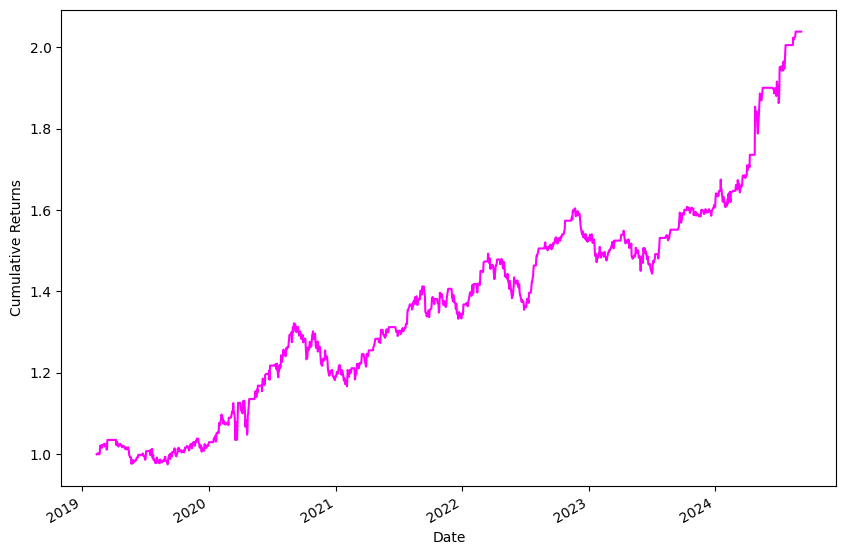

In [14]:
#plotting the cumulative returns of the strategy
df.cumulative_returns.plot(label='Returns', figsize=(10,7),color='magenta')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()

The maximum drawdown is -11.71


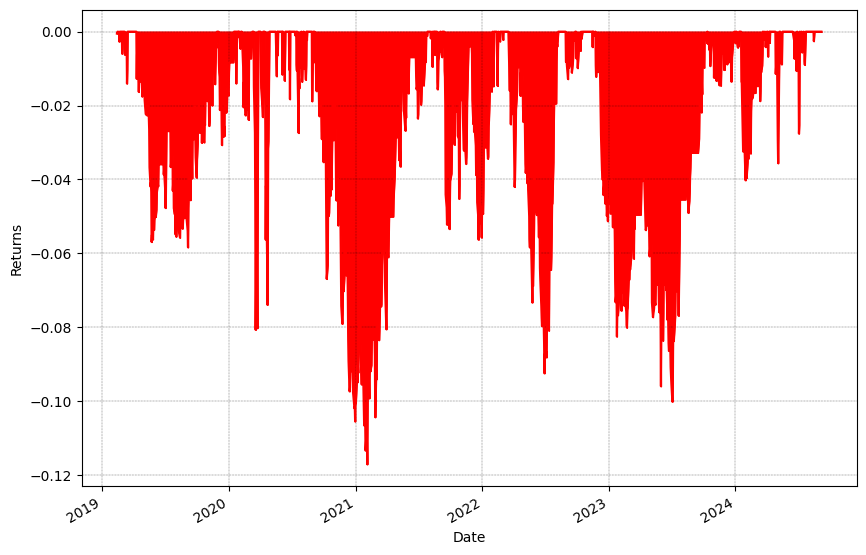

In [15]:
def calc_drawdown(cum_rets):
    # Calculate the running maximum
    running_max = np.maximum.accumulate(cum_rets.dropna())
    # Ensure the value never drops below 1
    running_max[running_max < 1] = 1
    # Calculate the percentage drawdown
    drawdown = (cum_rets)/running_max - 1
    return drawdown

def plot_drawdown(drawdown):
    fig = plt.figure(figsize=(10, 7))
    # Plot
    drawdown.plot(color='r')
    plt.ylabel('Returns')
    plt.fill_between(drawdown.index, drawdown, color='red')
    plt.grid(which="major", color='k', linestyle='-.', linewidth=0.2)
    plt.show()

drawdown_strategy = calc_drawdown(df.cumulative_returns)
print("The maximum drawdown is %.2f" % (drawdown_strategy.min()*100))
plot_drawdown(drawdown_strategy)

[*********************100%%**********************]  1 of 1 completed


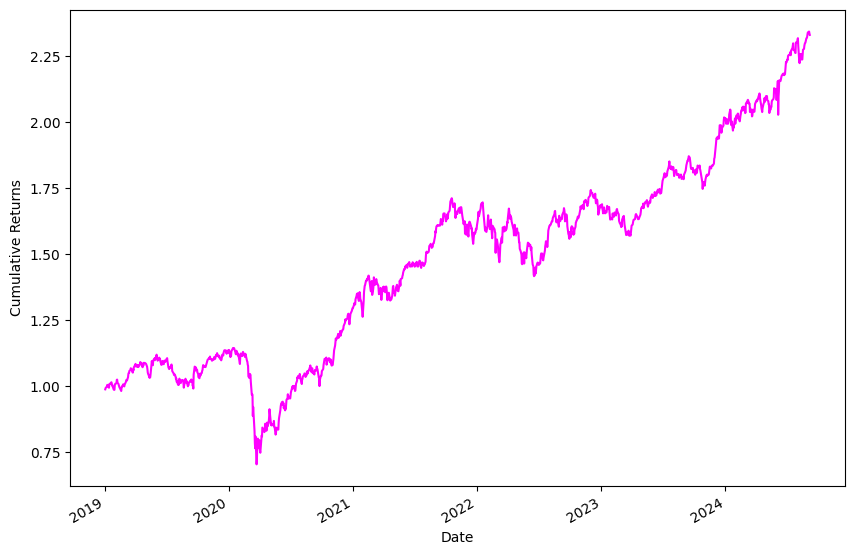

Date
2019-01-02    10792.500000
2019-01-03    10672.250000
2019-01-04    10727.349609
2019-01-07    10771.799805
2019-01-08    10802.150391
                  ...     
2024-08-30    25235.900391
2024-09-02    25278.699219
2024-09-03    25279.849609
2024-09-04    25198.699219
2024-09-05    25145.099609
Name: Adj Close, Length: 1399, dtype: float64

In [16]:
#to compare how our strategy performed , we will create an instance and compare the drawdown
start_date = '2019-01-01'
end_date = '2024-12-31'

nifty = yf.download('^NSEI', start=start_date, end=end_date)['Adj Close']
nifty.columns = ['Nifty']
nifty_cum_rets = (nifty.pct_change().dropna()+1).cumprod()
nifty_cum_rets.plot(label='Nifty', figsize=(10,7),color='magenta')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()
nifty

The maximum drawdown is -38.44


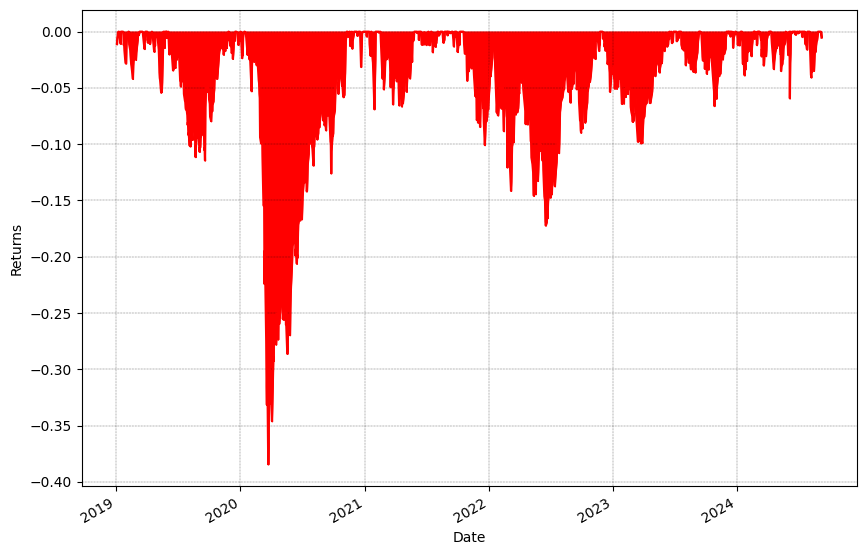

In [17]:
#drawdown_nifty
drawdown_nifty = calc_drawdown(nifty_cum_rets)
print("The maximum drawdown is %.2f" % (drawdown_nifty.min()*100))
plot_drawdown(drawdown_nifty)